# SIR model: inverse problem
## PINN solution - joint training

In this notebook, we will solve the inverse problem of the SIR model using a Physics-Informed Neural Network (PINN). The goal is to estimate the infection rate $\beta$ from the observed data of the infected population. To do this, we will train a PINN model using a **joint training** approach, where we compute the residuals of the SIR ODE and the initial conditions and the data loss simultaneously.

The SIR model is governed by the following set of ordinary differential equations (ODEs):

$$
\begin{cases}
\frac{dS}{dt} &= -\frac{\beta}{N} I S, \\
\frac{dI}{dt} &= \frac{\beta}{N} I S - \delta I, \\
\frac{dR}{dt} &= \delta I,
\end{cases}
$$

where $t \in [0, 90]$ and with the initial conditions $S(0) = N - 1$, $I(0) = 1$, and $R(0) = 0$.

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from IPython.display import display, HTML
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_percentage_error

# if torch.backends.mps.is_available():
#   torch.set_default_device("mps")

figures_dir = "figures"
data_dir = "data"
sns.set_theme(style="darkgrid")

timestamp = pd.Timestamp.now().strftime("%Y%m%d%H%M%S")

### Data Generation

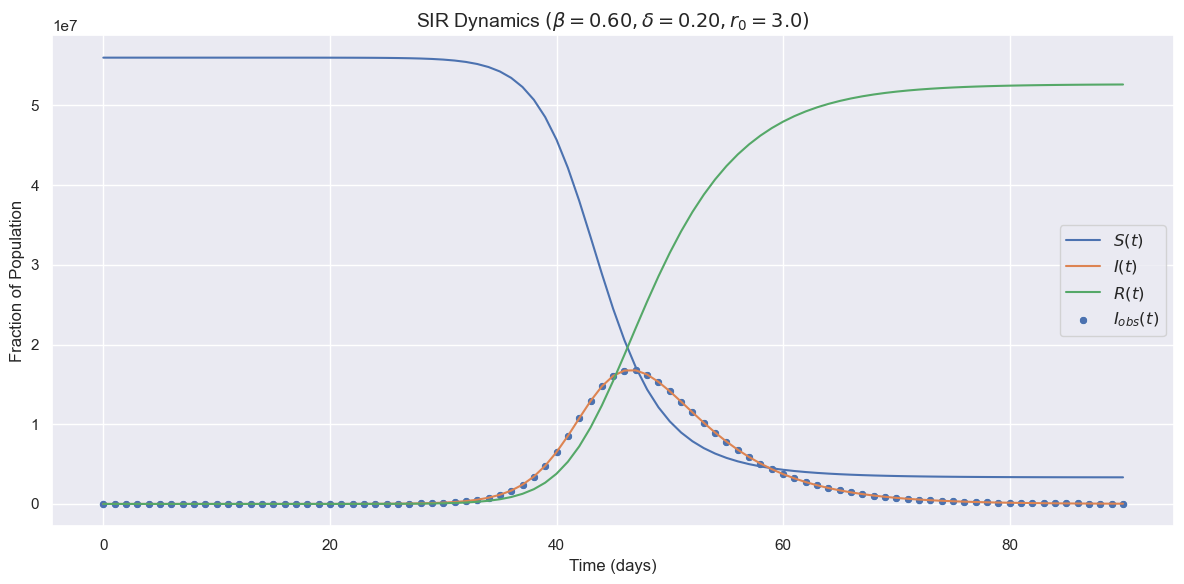

In [82]:
# True SIR parameters for data generation
N = 56e6  # Total population (for scaling)
delta = 1 / 5  # Recovery rate (per day)
r0 = 3.0  # Basic reproduction number
beta_true = delta * r0  # Infection rate (per day)


def sir(x, _, d, b):
  s, i, r = x
  l = b * i / N
  ds_dt = -l * s
  di_dt = l * s - d * i
  dr_dt = d * i
  return np.array([ds_dt, di_dt, dr_dt])


# Initial conditions (actual population counts)
S0 = N - 1
I0 = 1
R0 = 0

# Time domain for simulation
t_start, t_end = 0, 90  # days
t = np.linspace(t_start, t_end, t_end - t_start + 1)

solution = odeint(sir, [S0, I0, R0], t, args=(delta, beta_true))
s_true = solution[:, 0]
i_true = solution[:, 1]
r_true = solution[:, 2]

i_obs = np.random.poisson(i_true)

plt.subplots(figsize=(12, 6))

sns.lineplot(x=t, y=s_true, label=r"$S(t)$")
sns.lineplot(x=t, y=i_true, label=r"$I(t)$")
sns.lineplot(x=t, y=r_true, label=r"$R(t)$")
sns.scatterplot(x=t, y=i_obs, label=r"$I_{obs}(t)$")

plt.title(
  f"SIR Dynamics $\\left(\\beta={beta_true:.2f}, \\delta={delta:.2f}, r_0={r0}\\right)$",
  fontsize=14
)
plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Fraction of Population", fontsize=12)

plt.legend(fontsize=12, loc="center right")

plt.tight_layout()

plt.savefig(f"{figures_dir}/synthetic_data.png", dpi=300)

### Data Preprocessing

In [83]:
s_true = s_true / N
i_true = i_true / N
r_true = r_true / N

ic = np.array([S0, I0, R0]) / N
i_obs = i_obs / N

# Convert observation data to torch tensors for training
t0_tensor = torch.tensor([[0.0]], dtype=torch.float32)
ic_tensor = torch.tensor(ic, dtype=torch.float32).reshape(1, -1)

t_tensor = torch.tensor(t, dtype=torch.float32).reshape(-1, 1)
i_obs_tensor = torch.tensor(i_obs, dtype=torch.float32).reshape(-1, 1)

### Model Definition

In [84]:
class Square(nn.Module):
  """
  A module that squares its input element-wise.
  Useful as a final activation to enforce non-negativity.
  """

  @staticmethod
  def forward(x):
    return torch.square(x)


def create_fnn(layers_dimensions, activation, output_activation):
  layers_modules = []
  for i in range(len(layers_dimensions) - 1):
    layers_modules.append(
      nn.Linear(layers_dimensions[i], layers_dimensions[i + 1])
    )
    if i < len(layers_dimensions) - 2:
      layers_modules.append(activation)
  layers_modules.append(output_activation)

  net = nn.Sequential(*layers_modules)

  # Initialize weights and biases (Xavier initialization for weights, zeros for biases)
  for m in net:
    if isinstance(m, nn.Linear):
      nn.init.xavier_normal_(m.weight)
      nn.init.zeros_(m.bias)

  return net


class PINN(nn.Module):
  def __init__(
      self,
      given_N,
      given_delta,
      given_initial_beta,
      layers_dimensions,
      activation,
      output_activation,
  ):
    if layers_dimensions is None:
      layers_dimensions = [1] + [50] * 3 + [1]

    super(PINN, self).__init__()
    self.net_S = create_fnn(layers_dimensions, activation, output_activation)
    self.net_I = create_fnn(layers_dimensions, activation, output_activation)

    self.beta = torch.nn.Parameter(
      torch.tensor(given_initial_beta, dtype=torch.float32)
    )
    self.delta = given_delta
    self.N = torch.tensor(given_N, dtype=torch.float32)

  def forward(self, x):
    S = self.net_S(x)
    I = self.net_I(x)
    R = self.N.to(x.device) - S - I

    return torch.cat([S, I, R], dim=1)

  def compute_pde_residuals(self, x):
    """Compute residuals of SIR ODE at times t.
    Returns tensors of the same shape as t."""
    x.requires_grad_(True)
    S = self.net_S(x)
    I = self.net_I(x)

    dS_dt = torch.autograd.grad(
      S, x, grad_outputs=torch.ones_like(S), create_graph=True
    )[0]
    dI_dt = torch.autograd.grad(
      I, x, grad_outputs=torch.ones_like(I), create_graph=True
    )[0]

    res_S = dS_dt + self.beta * S * I
    res_I = dI_dt - self.beta * S * I + self.delta * I
    return res_S, res_I

### Hyperparameters

In [85]:
use_saved_model = False  # whether to explicitly trigger a new training

iterations = 5000 * 60  # number of optimizer steps
sampling_points = 100  # number of points to sample each step for computing losses

learning_rate = 1e-3  # optimizer learning rate
patience = 4000  # number of steps without loss improvement to stop training
log_interval = 1000  # for debug purpose, number of steps between logging training info

weights_update_rate = 6000  # number of steps between updates of the weighted sum's weights
initial_weight_pde = 0.1  # initial weight for PDE loss
initial_weight_ic = 0.45  # initial weight for IC loss
# initial_weight_data = 1 - initial_weight_pde - initial_weight_ic
smoothing_factor = 0.9  # smoothing factor for weights updates

layers = [1] + [50] * 4 + [1]  # neural network architecture
activation_fn = nn.Tanh()  # activation function for hidden layers
output_activation_fn = nn.Softplus()  # activation function for output layer

loss_fn = nn.MSELoss()  # selected loss function: Mean Squared Error

initial_beta = 0.3  # initial value for beta parameter

### Training

In [86]:
model = PINN(
  given_N=1.0,
  given_delta=delta,
  given_initial_beta=initial_beta,
  layers_dimensions=layers,
  activation=activation_fn,
  output_activation=output_activation_fn
)

adam_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adam_optimizer)

loss_df = pd.DataFrame(
  columns=[
    "weight_pde", "L_pde",
    "weight_ic", "L_ic",
    "weight_data", "L_data",
    "total_loss"
  ]
)
evolution_df = pd.DataFrame(columns=["beta"])

In [87]:
def loss_pde(x):
  res_S, res_I = model.compute_pde_residuals(x)
  loss_res_S = loss_fn(res_S, torch.zeros_like(res_S))
  loss_res_I = loss_fn(res_I, torch.zeros_like(res_I))
  return loss_res_S + loss_res_I


def loss_ic():
  ic_pred = model(t0_tensor)
  return loss_fn(ic_pred, ic_tensor)


def loss_data():
  I = model(t_tensor)[:, 1].reshape(-1, 1)
  return loss_fn(I, i_obs_tensor)

In [88]:
L_pde_history = []
L_ic_history = []
L_data_history = []
loss_history = []
weight_ode_history = []
weight_ic_history = []
weight_data_history = []
beta_evolution = []


def train():
  best_lost = np.inf
  no_improvement = 0

  weight_pde = torch.tensor(initial_weight_pde)
  weight_ic = torch.tensor(initial_weight_ic)
  weight_data = torch.tensor(1 - initial_weight_pde - initial_weight_ic)
  eps = 1e-5  # small constant for numerical stability

  for it in range(1, iterations + 1):
    adam_optimizer.zero_grad()

    t_sample = torch.rand(sampling_points, 1) * t_end

    L_pde = loss_pde(t_sample)
    L_ic = loss_ic()
    L_data = loss_data()

    if it % weights_update_rate == 0:
      grads_pde = torch.autograd.grad(
        L_pde, model.parameters(), retain_graph=True, create_graph=False
      )
      ic_params = list(model.net_S.parameters()) + list(
        model.net_I.parameters()
      )
      grads_ic = torch.autograd.grad(
        L_ic, ic_params, retain_graph=True, create_graph=False
      )
      data_params = ic_params
      grads_data = torch.autograd.grad(
        L_data, data_params, retain_graph=True, create_graph=False
      )

      grad_norm_pde = torch.cat([g.flatten() for g in grads_pde]).norm()
      grad_norm_ic = torch.cat([g.flatten() for g in grads_ic]).norm()
      grad_norm_data = torch.cat([g.flatten() for g in grads_data]).norm()

      new_weight_pde = 1 / (grad_norm_pde + eps)
      new_weight_ic = 1 / (grad_norm_ic + eps)
      new_weight_data = 1 / (grad_norm_data + eps)

      # normalize weights
      weight_sum = new_weight_pde + new_weight_ic + new_weight_data
      new_weight_pde /= weight_sum
      new_weight_ic /= weight_sum
      new_weight_data /= weight_sum

      weight_pde = smoothing_factor * weight_pde + \
                   (1 - smoothing_factor) * new_weight_pde
      weight_ic = smoothing_factor * weight_ic + \
                  (1 - smoothing_factor) * new_weight_ic
      weight_data = smoothing_factor * weight_data + \
                    (1 - smoothing_factor) * new_weight_data

    loss = (
        weight_pde * L_pde +
        weight_ic * L_ic +
        weight_data * L_data
    )

    loss.backward()
    adam_optimizer.step()
    # scheduler.step(loss)

    L_pde_history.append(L_pde.item())
    L_ic_history.append(L_ic.item())
    L_data_history.append(L_data.item())
    loss_history.append(loss.item())
    weight_ode_history.append(weight_pde.item())
    weight_ic_history.append(weight_ic.item())
    weight_data_history.append(weight_data.item())
    beta_evolution.append(model.beta.item())

    if it % log_interval == 0:
      print(
        f"[{it:<{len(str(iterations))}}/{iterations}]: "
        f"β = {model.beta.item():.4f} "
        f"| Loss = {loss.item():.2e} "
        f"| lr = {scheduler.get_last_lr()[0]:.2e}"
      )

    # if loss.item() < best_lost:
    #   best_lost = loss.item()
    #   no_improvement = 0
    # else:
    #   no_improvement += 1
    #
    # if no_improvement >= patience:
    #   print(f"[{it}/{iterations}]: Patience reached, stopping training.")
    #   break

  save_training()


def save_training():
  if not weight_ode_history:
    return
  loss_df['weight_pde'] = weight_ode_history
  loss_df['L_pde'] = L_pde_history
  loss_df['weight_ic'] = weight_ic_history
  loss_df['L_ic'] = L_ic_history
  loss_df['weight_data'] = weight_data_history
  loss_df['L_data'] = L_data_history
  loss_df['total_loss'] = loss_history

  evolution_df['beta'] = beta_evolution

  loss_df.to_csv(f"{data_dir}/loss_history.csv", float_format='%.6e')
  evolution_df.to_csv(f"{data_dir}/beta_history.csv", float_format='%.6e')

  torch.save(model.state_dict(), f"{data_dir}/model.pth")

In [89]:
if use_saved_model:
  try:
    state_dict = torch.load(f"{data_dir}/model.pth", weights_only=True)
    model.load_state_dict(state_dict)
    loss_df = pd.read_csv(f"{data_dir}/loss_history.csv")
    evolution_df = pd.read_csv(f"{data_dir}/beta_history.csv")
  except FileNotFoundError:
    train()
else:
  train()

[1000  /300000]: β = 0.2867 | Loss = 1.80e-03 | lr = 1.00e-03
[2000  /300000]: β = 0.2828 | Loss = 2.53e-03 | lr = 1.00e-03
[3000  /300000]: β = 0.2739 | Loss = 3.38e-03 | lr = 1.00e-03
[4000  /300000]: β = 0.3467 | Loss = 2.06e-05 | lr = 1.00e-03
[5000  /300000]: β = 0.5212 | Loss = 3.93e-06 | lr = 1.00e-03
[6000  /300000]: β = 0.5806 | Loss = 1.25e-06 | lr = 1.00e-03
[7000  /300000]: β = 0.5956 | Loss = 2.69e-06 | lr = 1.00e-03
[8000  /300000]: β = 0.5957 | Loss = 4.55e-07 | lr = 1.00e-03
[9000  /300000]: β = 0.5964 | Loss = 1.68e-06 | lr = 1.00e-03
[10000 /300000]: β = 0.5971 | Loss = 2.85e-06 | lr = 1.00e-03
[11000 /300000]: β = 0.5961 | Loss = 1.88e-06 | lr = 1.00e-03
[12000 /300000]: β = 0.5878 | Loss = 4.76e-07 | lr = 1.00e-03
[13000 /300000]: β = 0.5954 | Loss = 3.27e-07 | lr = 1.00e-03
[14000 /300000]: β = 0.5943 | Loss = 2.37e-07 | lr = 1.00e-03
[15000 /300000]: β = 0.5974 | Loss = 4.01e-07 | lr = 1.00e-03
[16000 /300000]: β = 0.5919 | Loss = 8.25e-08 | lr = 1.00e-03
[17000 /

### Evaluation

In [90]:
# save_training()
t_pred = t_tensor.cpu().detach().numpy().flatten()
s_pred, i_pred, r_pred = model(t_tensor).cpu().detach().numpy().T
beta_pred = model.beta.item()

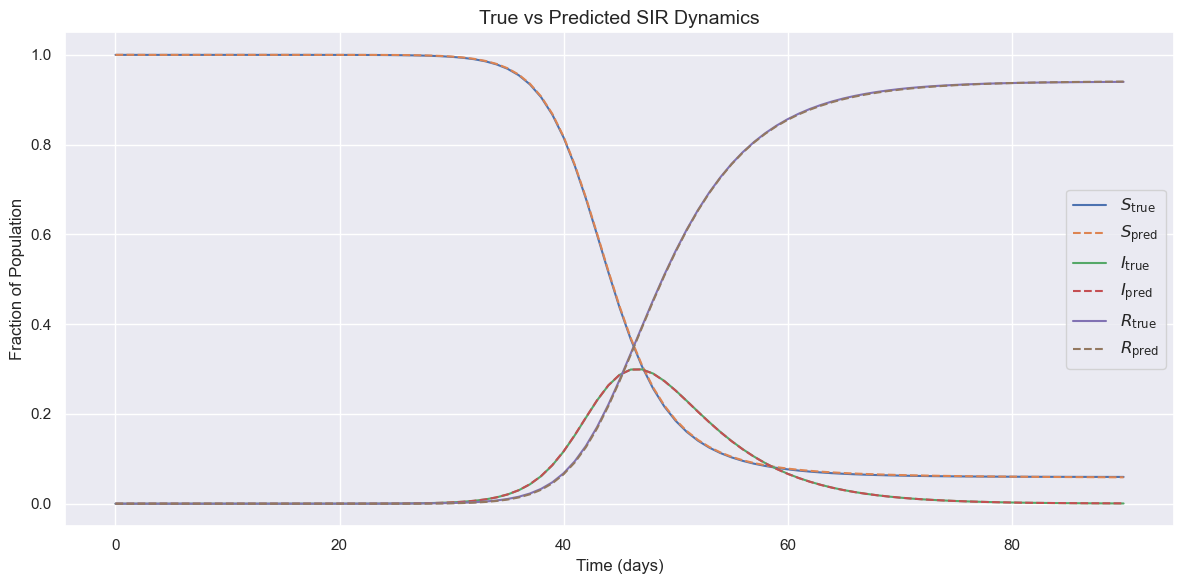

In [91]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=t_pred, y=s_true, label="$S_{\mathrm{true}}$")
sns.lineplot(x=t_pred, y=s_pred, label="$S_{\mathrm{pred}}$", linestyle="--")
sns.lineplot(x=t_pred, y=i_true, label="$I_{\mathrm{true}}$")
sns.lineplot(x=t_pred, y=i_pred, label="$I_{\mathrm{pred}}$", linestyle="--")
sns.lineplot(x=t_pred, y=r_true, label="$R_{\mathrm{true}}$")
sns.lineplot(x=t_pred, y=r_pred, label="$R_{\mathrm{pred}}$", linestyle="--")

plt.title('True vs Predicted SIR Dynamics', fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Fraction of Population', fontsize=12)

plt.legend(fontsize=12, loc='center right')

plt.tight_layout()

if not use_saved_model:
  plt.savefig(f"{figures_dir}/sir_predictions_{timestamp}.png", dpi=300)

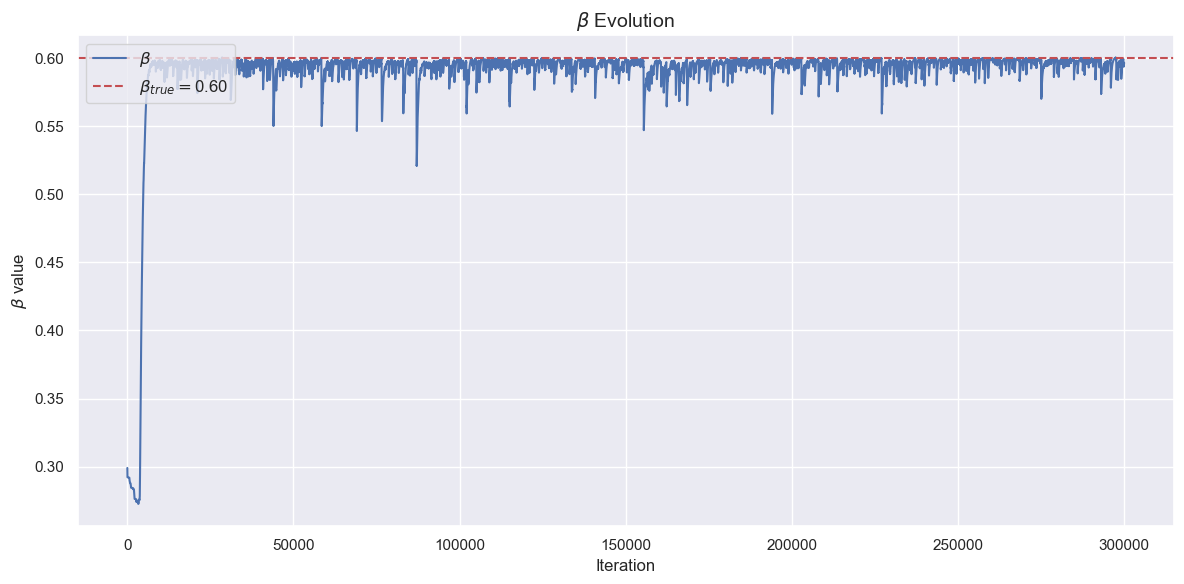

In [92]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=evolution_df['beta'], label='$\\beta$')
plt.axhline(
  y=beta_true,
  color='r',
  linestyle='--',
  label='$\\beta_{true} = $' + f'{beta_true:.2f}'
)

plt.title(f'$\\beta$ Evolution', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('$\\beta$ value', fontsize=12)

plt.legend(fontsize=12, loc='upper left')

plt.tight_layout()

if not use_saved_model:
  plt.savefig(f'{figures_dir}/beta_evolution_{timestamp}.png', dpi=300)

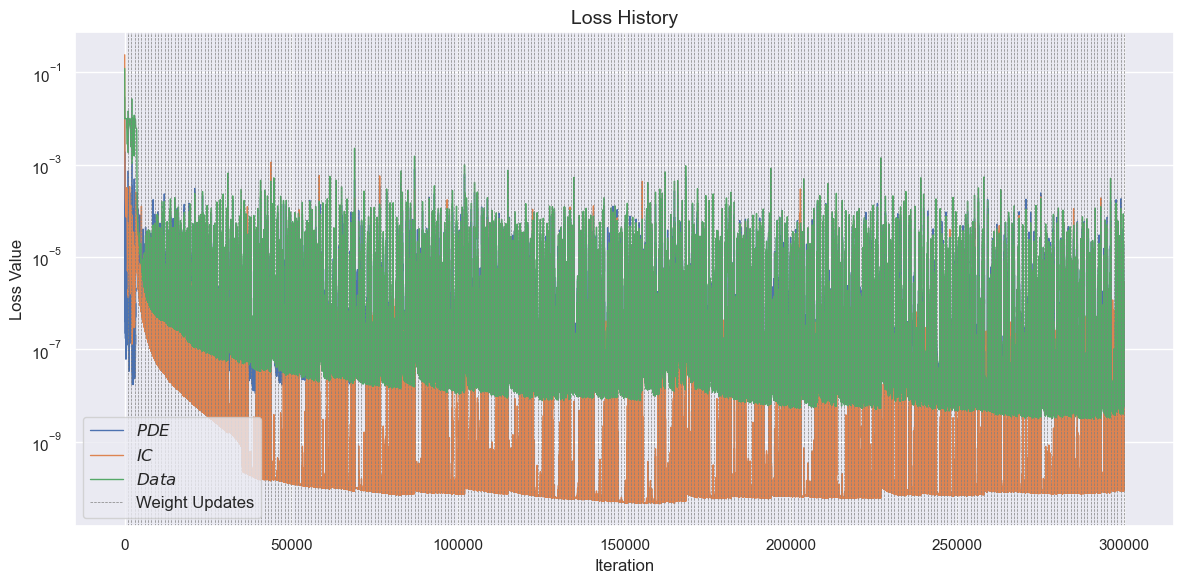

In [93]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=loss_df['L_pde'], label='$PDE$', linewidth=1)
sns.lineplot(data=loss_df['L_ic'], label='$IC$', linewidth=1)
sns.lineplot(data=loss_df['L_data'], label='$Data$', linewidth=1)

plt.title('Loss History', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.yscale('log')

plt.axvline(
  x=weights_update_rate,
  color='gray',
  linestyle='--',
  linewidth=0.5,
  label='Weight Updates'
)
for w in range(weights_update_rate * 2, len(loss_df) + 1, weights_update_rate):
  plt.axvline(x=w, color='gray', linestyle='--', linewidth=0.5)

plt.legend(fontsize=12, loc='lower left')

plt.tight_layout()

if not use_saved_model:
  plt.savefig(f'{figures_dir}/loss_history_{timestamp}.png', dpi=300)

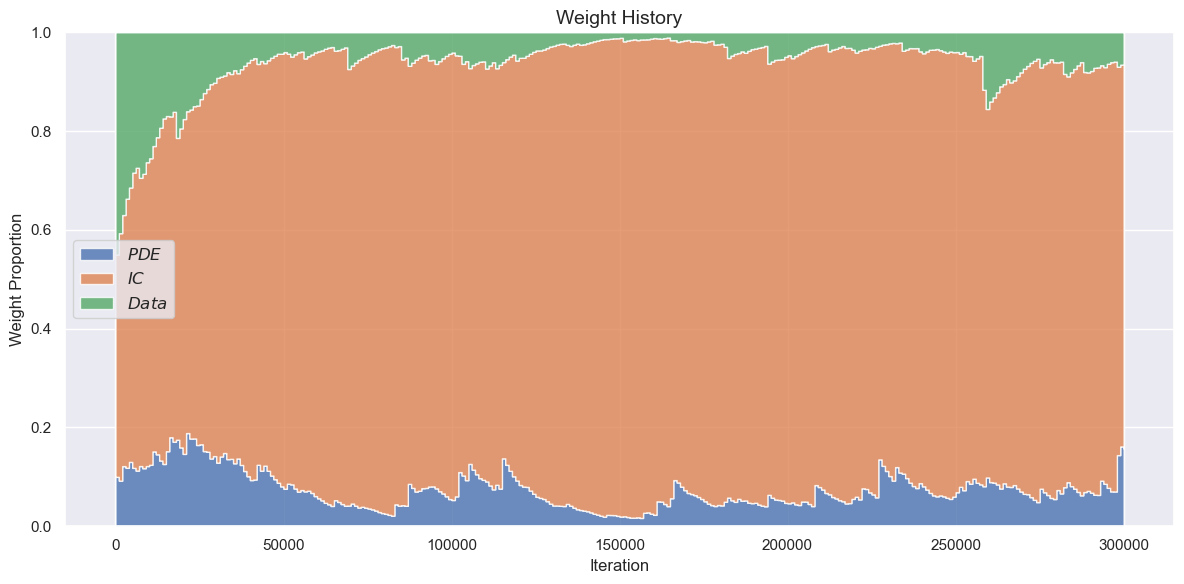

In [94]:
plt.figure(figsize=(12, 6))

plt.stackplot(
  loss_df.index,
  loss_df['weight_pde'],
  loss_df['weight_ic'],
  loss_df['weight_data'],
  labels=['$PDE$', '$IC$', '$Data$'],
  alpha=0.8
)

plt.title('Weight History', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Weight Proportion', fontsize=12)

plt.ylim(0, 1)
plt.legend(fontsize=12, loc='center left')

plt.tight_layout()

if not use_saved_model:
  plt.savefig(f'{figures_dir}/weight_history_{timestamp}.png', dpi=300)


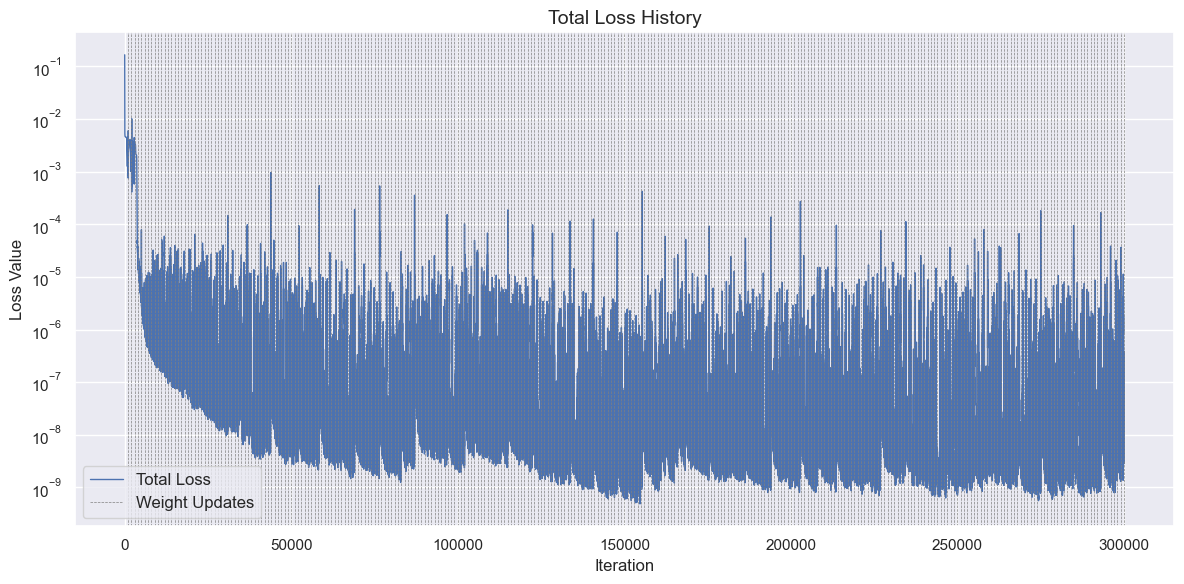

In [95]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=loss_df['total_loss'], label='Total Loss', linewidth=1)

plt.title('Total Loss History', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.yscale('log')

plt.axvline(
  x=weights_update_rate,
  color='gray',
  linestyle='--',
  linewidth=0.5,
  label='Weight Updates'
)
for w in range(weights_update_rate * 2, len(loss_df) + 1, weights_update_rate):
  plt.axvline(x=w, color='gray', linestyle='--', linewidth=0.5)

plt.legend(fontsize=12, loc='lower left')

plt.tight_layout()

if not use_saved_model:
  plt.savefig(f'{figures_dir}/total_loss_history_{timestamp}.png', dpi=300)

In [96]:
def mse(pred, true):
  """Calculate Mean Squared Error between predicted and true values."""
  return np.mean((pred - true) ** 2)


def re(pred, true):
  """Calculate Relative Error between predicted and true values."""
  return np.linalg.norm(true - pred, 2) / np.linalg.norm(true, 2)


def mape(pred, true):
  """Calculate Mean Absolute Percentage Error between predicted and true values."""
  return mean_absolute_percentage_error(true, pred)


compartments = ["S", "I", "R"]
pred_arrays = [s_pred, i_pred, r_pred]
true_arrays = [s_true, i_true, r_true]

mse_values = [
  f"{mse(pred, true):.2e}" for pred, true in zip(pred_arrays, true_arrays)
]
re_values = [
  f"{re(pred, true):.2e}" for pred, true in zip(pred_arrays, true_arrays)
]
mape_values = [
  f"{mape(pred, true):.2e}" for pred, true in zip(pred_arrays, true_arrays)
]

errors = pd.DataFrame(
  {
    "Compartment": compartments,
    "MSE":         mse_values,
    "MAPE (%)":    mape_values,
    "RE":          re_values,
  }
)

display(HTML(errors.to_html(index=False)))

Compartment,MSE,MAPE (%),RE
S,1.60e-06,7.39e-03,1.85e-03
I,3.39e-08,8.10e+01,1.83e-03
R,1.56e-06,3.15e+09,2.08e-03


In [97]:
beta_error = abs(beta_pred - beta_true)
beta_error_percent = beta_error / beta_true * 100

beta_errors = pd.DataFrame(
  {
    "Parameter":          ["β"],
    "Predicted Value":    [f"{beta_pred:.4f}"],
    "True Value":         [f"{beta_true:.4f}"],
    "Absolute Error":     [f"{beta_error:.2e}"],
    "Relative Error (%)": [f"{beta_error_percent:.2f}%"],
  }
)

display(HTML(beta_errors.to_html(index=False)))

Parameter,Predicted Value,True Value,Absolute Error,Relative Error (%)
β,0.5966,0.6000,3.39e-03,0.56%
